# Description
### Utilisation du framework [edspdf](https://github.com/aphp/edspdf) pour tester la détection automatique du layout des PDF. 
### Ajustement du mask-classifier et ajout d'une ligne de code dans le fichier de configuration pour extraire correctement le corps du texte et le style. 
### Visualisation des blocs de texte après installation de la librairie Pillows.

## Extraction de texte et de style

#### Chargement du modèle à partir du fichier de configuration

In [2]:
import edspdf
from pathlib import Path

model = edspdf.load("config.cfg") 

#### Récupération du courrier modèle de l'APHP en PDF

In [3]:
# Get a PDF
pdf = Path("letter.pdf").read_bytes()
pdf = model(pdf)

body = pdf.aggregated_texts["body"]

text, style = body.text, body.properties

#### Extraction de texte

In [5]:
import pandas as pd

print(text)

Cher Pr ABC, Cher DEF,

SANTÉ PUBLIQUE
Nous souhaitons remercier le CSE pour son avis favorable quant à l’accès aux données de
l’Entrepôt de Données de Santé du projet n° XXXX.

Nous avons bien pris connaissance des conditions requises pour cet avis favorable, c’est
pourquoi nous nous engageons par la présente à :

• Informer individuellement les patients concernés par la recherche, admis à l'AP-HP
avant juillet 2017, sortis vivants, et non réadmis depuis.

• Effectuer une demande d'autorisation à la CNIL en cas d'appariement avec d’autres
cohortes.

Bien cordialement,


#### Extraction de style

In [6]:
print(pd.DataFrame(style))

Empty DataFrame
Columns: []
Index: []


> **Avec le fichier de configuration de base, deux problèmes se posent:** 
>- **pour l'extraction de texte, "SANTÉ PUBLIQUE" ne devrait pas apparaître.**
>- **l'extraction de style ne semble pas fonctionner.**

## Ajustement de mask-classifier

Dans le fichier de configuration, x0, x1, y0, y1 sont les coordonnées qui encadrent la partie de la page où le texte est considéré comme important (le corps du texte).  
Tout texte qui tombe en dehors de ces limites est étiqueté comme pollution. 
   
> **On crée un nouveau fichier de configuration config_text où l'abcisse x0 passe de 0.2 à 0.3 (le corps démarre un peu plus à droite).**


In [7]:
model = edspdf.load("config_text.cfg")

pdf = model(pdf)
body = pdf.aggregated_texts["body"]
text, style = body.text, body.properties

In [8]:
print(text)

Cher Pr ABC, Cher DEF,

Nous souhaitons remercier le CSE pour son avis favorable quant à l’accès aux données de
l’Entrepôt de Données de Santé du projet n° XXXX.

Nous avons bien pris connaissance des conditions requises pour cet avis favorable, c’est
pourquoi nous nous engageons par la présente à :

• Informer individuellement les patients concernés par la recherche, admis à l'AP-HP
avant juillet 2017, sortis vivants, et non réadmis depuis.

• Effectuer une demande d'autorisation à la CNIL en cas d'appariement avec d’autres
cohortes.

Bien cordialement,


> **Comme on le souhaitait, SANTÉ PUBLIQUE ne figure plus dans le texte extrait.**

Remarque: on pourrait aussi jouer sur le paramètre threshold (seuil) (threshold = 0.1 signifie que si un bloc de texte tombe partiellement à l'intérieur des limites du masque, il doit recouvrir au moins 10% de la zone pour être classé comme "corps").

## Extraction du style

C'est pdfminer-extractor qui permet l'extraction de style mais le composant ne semble pas fonctionner.  
On crée un nouveau fichier de configuration config_text_style.cfg,

> **on y ajoute la ligne de code extract_style = true pour forcer l'extraction.**

In [9]:
model = edspdf.load("config_text_style.cfg")

pdf = model(pdf)
body = pdf.aggregated_texts["body"]
text, style = body.text, body.properties

In [10]:
df = pd.DataFrame(style)
print(df.to_string())

                                                                                          0
0      TextProperties(italic=False, bold=False, begin=0, end=22, fontname='BCDFEE+Calibri')
1     TextProperties(italic=False, bold=False, begin=24, end=90, fontname='BCDFEE+Calibri')
2     TextProperties(italic=False, bold=False, begin=90, end=91, fontname='BCDHEE+Calibri')
3    TextProperties(italic=False, bold=False, begin=91, end=111, fontname='BCDFEE+Calibri')
4   TextProperties(italic=False, bold=False, begin=112, end=113, fontname='BCDFEE+Calibri')
5   TextProperties(italic=False, bold=False, begin=113, end=114, fontname='BCDHEE+Calibri')
6   TextProperties(italic=False, bold=False, begin=114, end=161, fontname='BCDFEE+Calibri')
7   TextProperties(italic=False, bold=False, begin=163, end=247, fontname='BCDFEE+Calibri')
8   TextProperties(italic=False, bold=False, begin=247, end=248, fontname='BCDHEE+Calibri')
9   TextProperties(italic=False, bold=False, begin=248, end=251, fontname='BCDFE

> **Comme on le souhaitait, extract_style = true a permis de forcer l'extraction de style.**

## Visualisation

#### Visualisation par blocs de 2 couleurs distinctes

Il faut au préalable installer la librairie pillow pour pouvoir utiliser show_annotations de edspdf.visualization.  
Les versions récentes de pillow semblent présenter des incompatibilités, il faut revenir à une version antérieure.  
pip install Pillow==9.5.0

In [ ]:
#!pip install Pillow==9.5.0

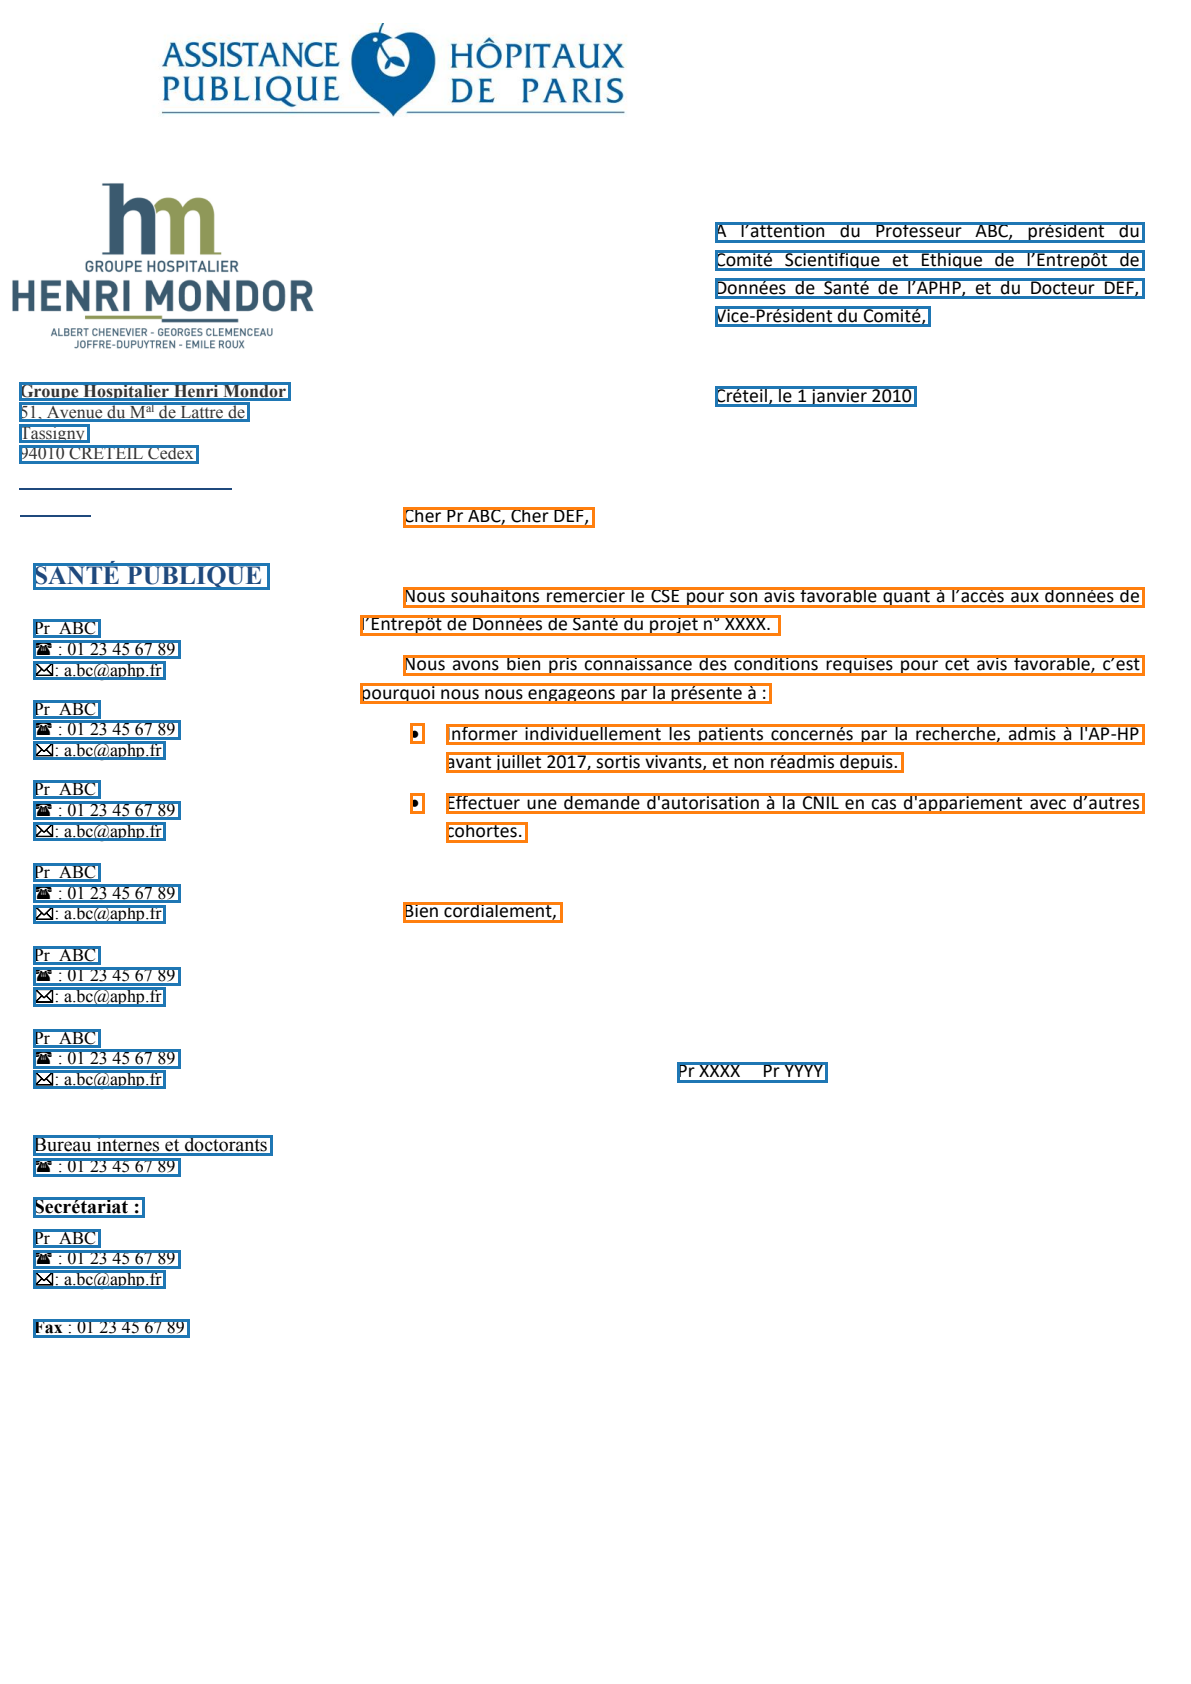

In [1]:
import edspdf
from pathlib import Path
from edspdf.visualization import show_annotations

model = edspdf.load("config_text_style.cfg")

pdf = Path("letter.pdf").read_bytes()

doc = model(pdf)

imgs = show_annotations(pdf=pdf, annotations=doc.text_boxes)

imgs[0]

#### Fusion des blocs de couleur similaire

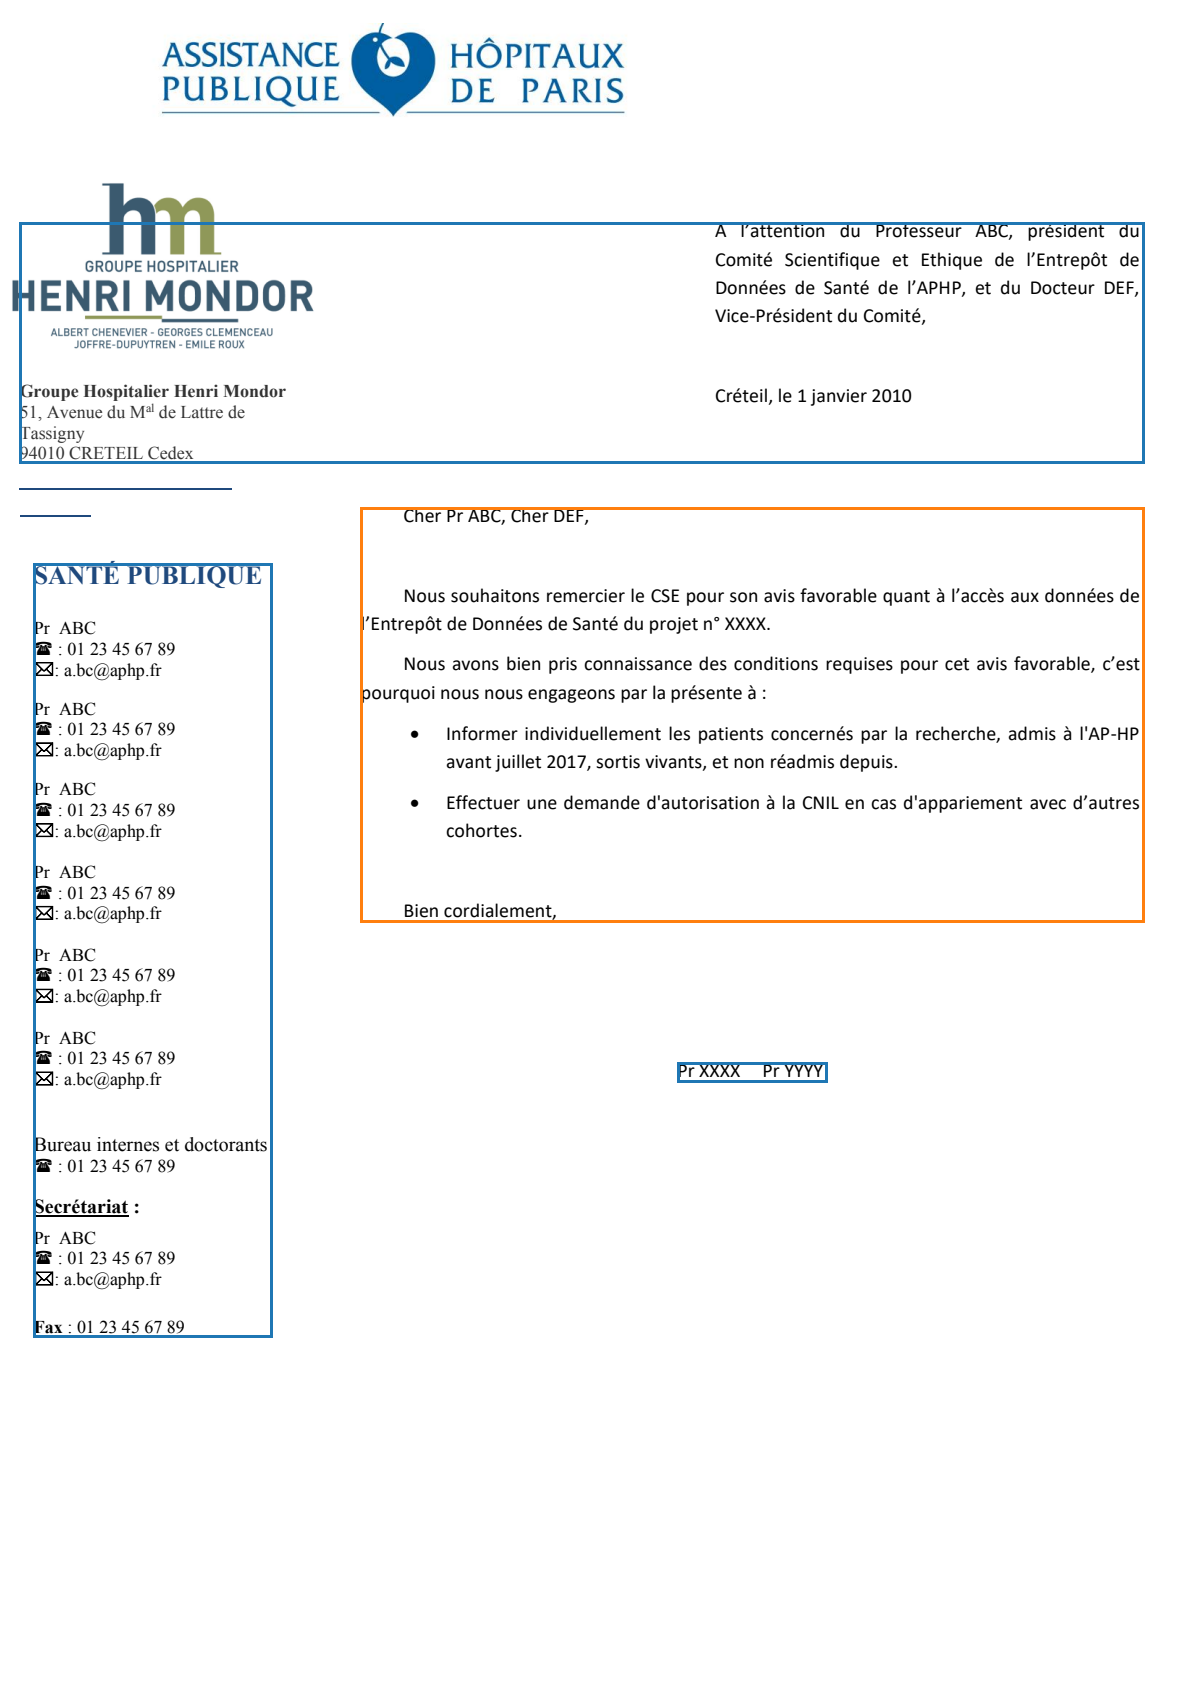

In [2]:
from edspdf.visualization import merge_boxes, show_annotations

merged = merge_boxes(doc.text_boxes)

imgs = show_annotations(pdf=pdf, annotations=merged)
imgs[0]